<a href="https://colab.research.google.com/github/AbhiJeet70/GraphPoisoningCodes/blob/main/Poison_Planetoid_Percentage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing dataset: Cora
Statistics for Cora:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
  Class distribution: [351 217 418 818 426 298 180]
Early stopping at epoch 151
Early stopping at epoch 143
Early stopping at epoch 253
Early stopping at epoch 250
Early stopping at epoch 104
Early stopping at epoch 138
Early stopping at epoch 120
Early stopping at epoch 292
Early stopping at epoch 208
Early stopping at epoch 101
Early stopping at epoch 116
Early stopping at epoch 112
Early stopping at epoch 157
Early stopping at epoch 186
Early stopping at epoch 126
Early stopping at epoch 126
Early stopping at epoch 144
Early stopping at epoch 160
Early stopping at epoch 421
Early stopping at epoch 436
Early stopping at epoch 150
Early stopping at epoch 123
Early stopping at epoch 148
Early stopping at epoch 149
Early stopping at epoch 342
Early stopping at epoch 372
Early stopping at epoch 130
Early stopping at epoch 129
Early stopping at e

/tmp/ipykernel_34/3182427344.py:215: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Perturbation Type: Evenly, Perturbation Percentage: 0.05, Accuracy: 0.8948339483394834
Number of nodes used for perturbation: 3
Early stopping at epoch 435
Perturbation Type: Concentrated, Perturbation Percentage: 0.05, Accuracy: 0.8782287822878229
Perturbation Type: Evenly, Perturbation Percentage: 0.1, Accuracy: 0.8671586715867159
Number of nodes used for perturbation: 8
Perturbation Type: Concentrated, Perturbation Percentage: 0.1, Accuracy: 0.8579335793357934
Perturbation Type: Evenly, Perturbation Percentage: 0.15, Accuracy: 0.8044280442804428
Number of nodes used for perturbation: 16
Early stopping at epoch 474
Perturbation Type: Concentrated, Perturbation Percentage: 0.15, Accuracy: 0.8376383763837638
Perturbation Type: Evenly, Perturbation Percentage: 0.2, Accuracy: 0.7601476014760148
Number of nodes used for perturbation: 29
Early stopping at epoch 459
Perturbation Type: Concentrated, Perturbation Percentage: 0.2, Accuracy: 0.8302583025830258
Perturbation Type: Evenly, Perturb

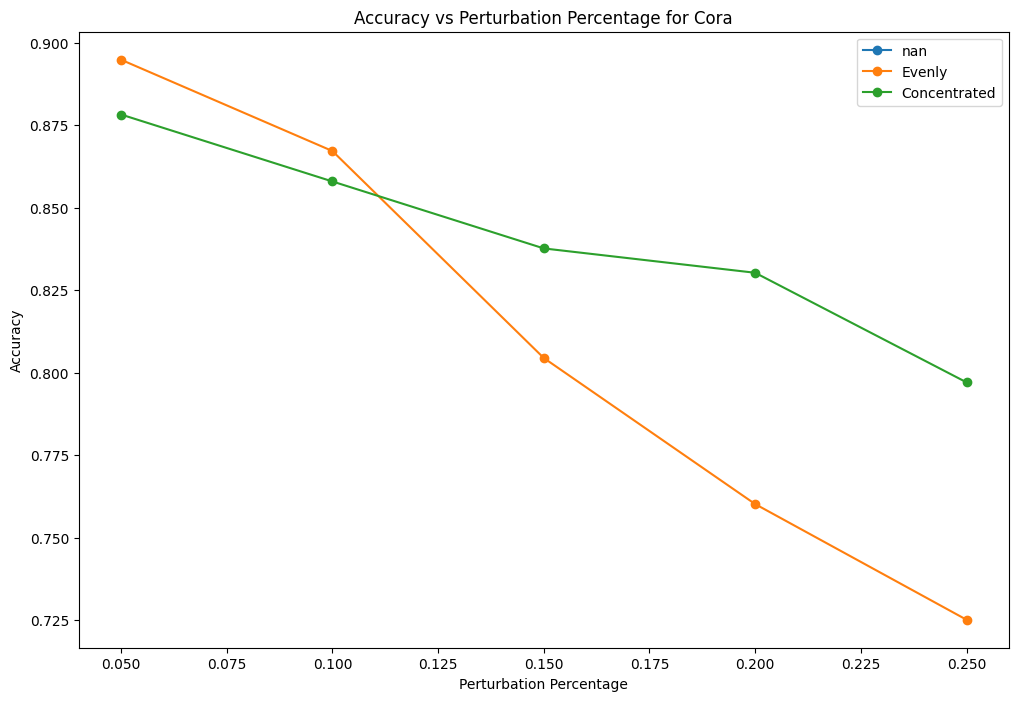

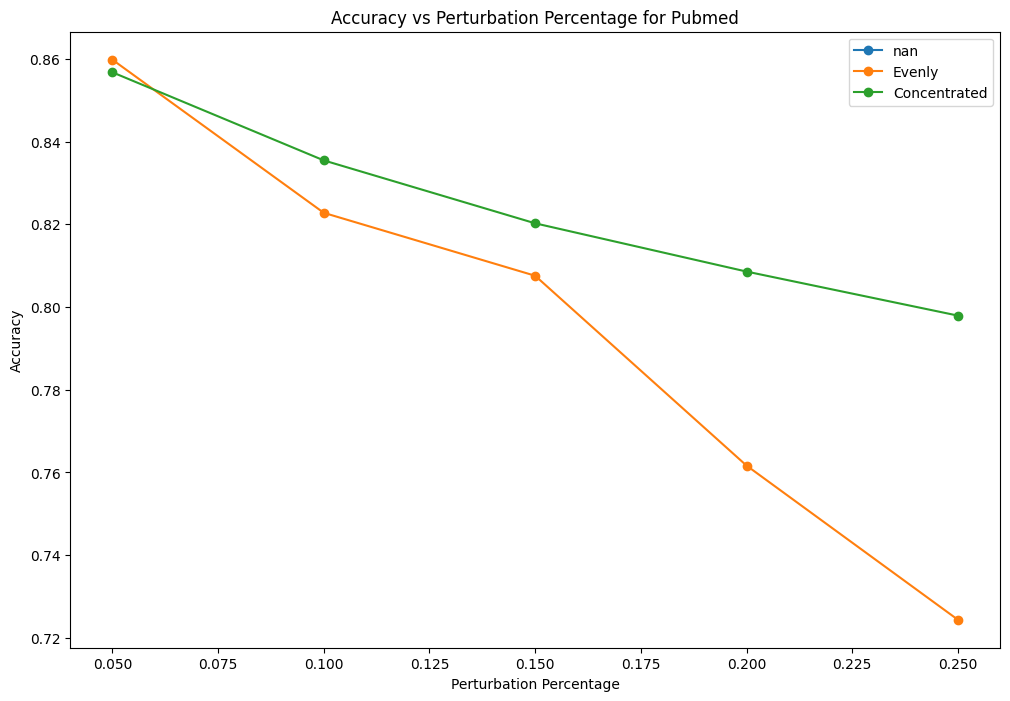

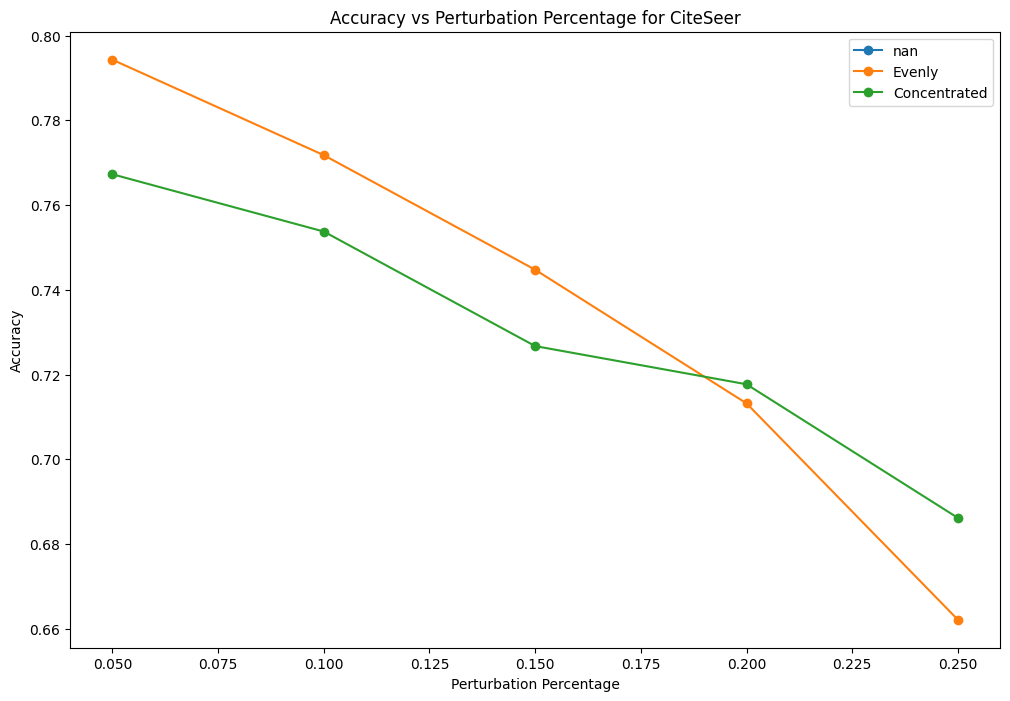

In [ ]:
# Install necessary packages
!pip install torch torch-geometric pandas matplotlib

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(20)

# Define function to load Planetoid data for a given dataset name
def load_planetoid_data(dataset_name):
    dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name, transform=NormalizeFeatures())
    data = dataset[0]
    return data

# Split data into train, validation, and test sets (if needed)
def split_indices(num_nodes, train_ratio=0.7, val_ratio=0.1):
    indices = np.random.permutation(num_nodes)
    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)
    train_idx = torch.tensor(indices[:train_end], dtype=torch.long)
    val_idx = torch.tensor(indices[train_end:val_end], dtype=torch.long)
    test_idx = torch.tensor(indices[val_end:], dtype=torch.long)
    return train_idx, val_idx, test_idx

# Define the GCN model with 2 layers
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train and evaluate the model
def train_model(model, pyg_data, lr, weight_decay):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pyg_data = pyg_data.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience = 100
    patience_counter = 0

    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(pyg_data.x, pyg_data.edge_index)
        loss = F.cross_entropy(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
        val_correct = float(pred[pyg_data.val_mask].eq(pyg_data.y[pyg_data.val_mask]).sum().item())
        val_acc = val_correct / pyg_data.val_mask.sum().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_model_state)
    model.eval()
    _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
    correct = float(pred[pyg_data.test_mask].eq(pyg_data.y[pyg_data.test_mask]).sum().item())
    acc = correct / pyg_data.test_mask.sum().item()
    return acc

# Print dataset statistics
def print_dataset_statistics(data, dataset_name):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_node_features
    num_classes = data.y.max().item() + 1
    class_distribution = torch.bincount(data.y).cpu().numpy()
    print(f"Statistics for {dataset_name}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Number of features: {num_features}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Class distribution: {class_distribution}")

def evenly_perturb_edges(data, perturbation_percentage):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    degrees = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long, device=device))

    for node in range(data.num_nodes):
        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        num_node_edges = connected_edges.sum().item()
        num_perturb_node_edges = int(num_node_edges * perturbation_percentage)

        if num_perturb_node_edges > 0:
            perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)
            perturb_edges_idx = perturb_edges_idx[torch.randperm(perturb_edges_idx.size(0))[:num_perturb_node_edges]]
            edge_index[:, perturb_edges_idx] = torch.randint(0, data.num_nodes, edge_index[:, perturb_edges_idx].shape, dtype=torch.long, device=device)

    data.edge_index = edge_index
    return data

def concentrated_perturb_edges(data, perturbation_percentage):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    num_perturbations = int(num_edges * perturbation_percentage)
    total_perturbations = 0
    nodes_used = 0

    degrees = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long, device=device))
    sorted_nodes = torch.argsort(degrees, descending=True)

    for node in sorted_nodes:
        if total_perturbations >= num_perturbations:
            break
        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        num_node_edges = connected_edges.sum().item()

        perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)
        num_perturb_node_edges = min(num_node_edges, num_perturbations - total_perturbations)
        edge_index[:, perturb_edges_idx[:num_perturb_node_edges]] = torch.randint(0, data.num_nodes, edge_index[:, perturb_edges_idx[:num_perturb_node_edges]].shape, dtype=torch.long, device=device)

        total_perturbations += num_perturb_node_edges
        nodes_used += 1

    data.edge_index = edge_index
    print(f"Number of nodes used for perturbation: {nodes_used}")
    return data, nodes_used

# Hyperparameter grid search
hidden_channels_list = [16, 32, 64, 128, 256, 512]  # Reduced for quicker testing
learning_rates = [0.1, 0.01, 0.001]    # Reduced for quicker testing
weight_decays = [1e-4, 1e-5]

# List of datasets to process
datasets = ['Cora', 'Pubmed', 'CiteSeer']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Dataset', 'Hidden_Channels', 'Learning_Rate', 'Weight_Decay', 'Accuracy', 'Perturbation_Type', 'Perturbation_Percentage'])

# Process each dataset and print accuracies
for dataset_name in datasets:
    print(f'Processing dataset: {dataset_name}')
    data = load_planetoid_data(dataset_name)
    print_dataset_statistics(data, dataset_name)

    train_idx, val_idx, test_idx = split_indices(data.num_nodes)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.val_mask[val_idx] = True
    data.test_mask[test_idx] = True

    # Determine number of classes from labels
    num_classes = data.y.max().item() + 1

    # Hyperparameter tuning
    best_accuracy = 0
    best_hyperparams = {}

    for hidden_channels in hidden_channels_list:
        for lr in learning_rates:
            for weight_decay in weight_decays:
                model = GCNNet(data.num_features, hidden_channels, num_classes)
                acc = train_model(model, data, lr, weight_decay)

                if acc > best_accuracy:
                    best_accuracy = acc
                    best_hyperparams = {
                        'Hidden_Channels': hidden_channels,
                        'Learning_Rate': lr,
                        'Weight_Decay': weight_decay
                    }

    # Report the best hyperparameters
    print(f"Best Hyperparameters for {dataset_name}: {best_hyperparams}")

    # Evaluate the best model
    model = GCNNet(data.num_features, best_hyperparams['Hidden_Channels'], num_classes)
    acc = train_model(model, data, best_hyperparams['Learning_Rate'], best_hyperparams['Weight_Decay'])
    print(f"Test Accuracy for {dataset_name}: {acc}")

    # Append results to DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Dataset': [dataset_name],
        'Hidden_Channels': [best_hyperparams['Hidden_Channels']],
        'Learning_Rate': [best_hyperparams['Learning_Rate']],
        'Weight_Decay': [best_hyperparams['Weight_Decay']],
        'Accuracy': [acc],
        'Perturbation_Type': ['None'],
        'Perturbation_Percentage': [0]
    })], ignore_index=True)

    # Perturbation experiments
    perturbation_percentages = [0.05, 0.1, 0.15, 0.2, 0.25]

    for perturbation_percentage in perturbation_percentages:
        for perturbation_type in ['Evenly', 'Concentrated']:
            perturbed_data = data.clone()
            if perturbation_type == 'Evenly':
                perturbed_data = evenly_perturb_edges(perturbed_data, perturbation_percentage)
            else:
                perturbed_data, nodes_used = concentrated_perturb_edges(perturbed_data, perturbation_percentage)

            model = GCNNet(data.num_features, best_hyperparams['Hidden_Channels'], num_classes)
            acc = train_model(model, perturbed_data, best_hyperparams['Learning_Rate'], best_hyperparams['Weight_Decay'])
            print(f"Perturbation Type: {perturbation_type}, Perturbation Percentage: {perturbation_percentage}, Accuracy: {acc}")

            # Append perturbed results to DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'Dataset': [dataset_name],
                'Hidden_Channels': [best_hyperparams['Hidden_Channels']],
                'Learning_Rate': [best_hyperparams['Learning_Rate']],
                'Weight_Decay': [best_hyperparams['Weight_Decay']],
                'Accuracy': [acc],
                'Perturbation_Type': [perturbation_type],
                'Perturbation_Percentage': [perturbation_percentage]
            })], ignore_index=True)

# Save results to a CSV file
results_df.to_csv('gcn_perturbation_results.csv', index=False)

# Plot results
def plot_results(df):
    datasets = df['Dataset'].unique()

    for dataset_name in datasets:
        fig, ax = plt.subplots(figsize=(12, 8))
        dataset_df = df[df['Dataset'] == dataset_name]

        for perturbation_type in dataset_df['Perturbation_Type'].unique():
            subset = dataset_df[dataset_df['Perturbation_Type'] == perturbation_type]
            ax.plot(subset['Perturbation_Percentage'], subset['Accuracy'], marker='o', label=f'{perturbation_type}')

        ax.set_xlabel('Perturbation Percentage')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Accuracy vs Perturbation Percentage for {dataset_name}')
        ax.legend()
        plt.show()

# Load the results from CSV
results_df = pd.read_csv('gcn_perturbation_results.csv')

# Plot the results
plot_results(results_df)
